In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import re 


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### Открывыем файл.

In [2]:
data = pd.read_csv('Cup_IT_2022_Датасет_Data_Science.csv').sort_index(axis=1)
data = data.drop(columns = ['client_id'])


### Словарь с группировкой по категориям.
Ключ - параметр<br> e.g. cnt_checks <br><br>
Значение - все параметры + категория <br>
e.g. 'cnt_checks_10_Крупы и зерновые'

In [3]:
columns = data.columns.tolist()
category_list = [
                 'Крупы и зерновые',
                 'Мясная гастрономия', 
                 'Овощи - Фрукты', 
                 'Птица и изделия из птицы', 
                 'Рыба и рыбные изделия', 
                 'Сыры',
                 '']
                 
parameters_list = [
                   'cnt_checks', 
                   'rto', 
                   'rto_stddev', 
                   'rto_std'
                   ]

output_dict = {}


for column in columns:
    for parameter in parameters_list:
        for category in  category_list:
            if category != '':
                regular = re.findall(f'{parameter}_\d+_{category}', column)
                key = f'{parameter}_{category}'
            else:
                regular = re.findall(f'{parameter}_\d+', column)
                key = f'{parameter}'
                
            if  len(regular) != 0 and regular[0]==column:
                if key not in output_dict.keys():
                    output_dict[key] = []
                    output_dict[key].append(column)
                else:
                    output_dict[key].append(column)


### Создание колонок

In [4]:
data = data.copy()

for key in output_dict.keys():
    data[key] = np.zeros(data.shape[0])
    if 'rto_stddev' not in key and 'rto_std' not in key:
        columns = output_dict[key]
        for column in columns:
            sum_column = data[column].fillna(0)
            data[key] += sum_column
        # data[key] = data[key] / len(columns)
        data = data.drop(columns = columns)
    else:
        columns = output_dict[key]
        mean = pd.DataFrame()
        mean['summary'] = np.zeros(data.shape[0])
        for column in columns:
            sum_column = data[column].fillna(0)
            mean['summary'] += sum_column
        mean['summary'] /= len(columns)
        data[key] = mean['summary']
        data = data.drop(columns = columns)

### Средний чек по категориям.

In [5]:
mean_dict = {
            'mean_rto_Крупы и зерновые' : ['cnt_checks_Крупы и зерновые', 'rto_Крупы и зерновые'], 
             'mean_rto_Мясная гастрономия' : ['cnt_checks_Мясная гастрономия', 'rto_Мясная гастрономия'],
             'mean_rto_Овощи - Фрукты' : ['cnt_checks_Овощи - Фрукты', 'rto_Овощи - Фрукты'],
             'mean_rto_Сыры' : ['cnt_checks_Сыры', 'rto_Сыры'],
             'mean_rto_Рыба и рыбные изделия' : ['cnt_checks_Рыба и рыбные изделия', 'rto_Рыба и рыбные изделия'],
             'mean_rto_Птица и изделия из птицы' : ['cnt_checks_Птица и изделия из птицы', 'rto_Птица и изделия из птицы'],
             'mean_rto' : ['cnt_checks', 'rto'],
            }

for key in mean_dict.keys():
    delimoe = data[mean_dict[key][1]]
    delit = data[mean_dict[key][0]]
    data[key] = delimoe/delit

for key in mean_dict.keys():
    data[key] = data[key].fillna(data[key].median())

In [6]:
data = data.drop(columns=['rto_stddev_Рыба и рыбные изделия', 'cnt_checks_Рыба и рыбные изделия'])

### rto больше 20к

In [7]:
def count_zeros(row):
  count = 0
  if row['cnt_checks_Крупы и зерновые'] == 0:
    count+=1
  if row['cnt_checks_Мясная гастрономия'] == 0:
    count+=1
  if row['cnt_checks_Овощи - Фрукты'] == 0:
    count+=1
  if row['cnt_checks_Птица и изделия из птицы'] == 0:
    count+=1
  if row['cnt_checks_Сыры'] == 0:
    count+=1
  return count

data['count_zeros'] = data.apply(count_zeros, axis=1)

In [8]:
data_1 = data.copy().drop(columns = 'count_zeros')

list_index = data[((data['count_zeros'] > 2) | (data['rto'] < 20000) | (data['cnt_checks'] < 15) ) & (data['is_in_club'] == 0)]['is_in_club'].index
data = data.drop(list_index, axis=0)
data = data.drop(columns = 'count_zeros')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81100 entries, 1 to 135058
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   is_in_club                           81100 non-null  int64  
 1   cnt_checks                           81100 non-null  float64
 2   cnt_checks_Крупы и зерновые          81100 non-null  float64
 3   cnt_checks_Мясная гастрономия        81100 non-null  float64
 4   cnt_checks_Овощи - Фрукты            81100 non-null  float64
 5   cnt_checks_Птица и изделия из птицы  81100 non-null  float64
 6   cnt_checks_Сыры                      81100 non-null  float64
 7   rto                                  81100 non-null  float64
 8   rto_Крупы и зерновые                 81100 non-null  float64
 9   rto_Мясная гастрономия               81100 non-null  float64
 10  rto_Овощи - Фрукты                   81100 non-null  float64
 11  rto_Птица и изделия из птиц

### Обучение

In [39]:
features = data.drop(columns=['is_in_club'])
target =  data['is_in_club']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.3, random_state=666, stratify=target)

print(features_test.shape, target_test.shape)

(24330, 26) (24330,)


In [40]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
 
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
 
    return features_downsampled, target_downsampled
 
 
 
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
 
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
 
    return features_upsampled, target_upsampled
 
 
features_train, target_train = downsample(features_train, target_train, 0.6)
print(target_train.value_counts(normalize=True))
print(features_train.shape, target_train.shape)
 
  
 
features_train, target_train = upsample(features_train, target_train, 2)
print(target_train.value_counts(normalize=True))
print(features_train.shape, target_train.shape)

0    0.768428
1    0.231572
Name: is_in_club, dtype: float64
(37539, 26) (37539,)
0    0.62394
1    0.37606
Name: is_in_club, dtype: float64
(46232, 26) (46232,)


In [12]:
def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score,
                   'precision' : precision_score,
                   'recall' : recall_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn =  models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5,param_grid=params, n_jobs=-1, scoring = 'f1')
            
           
            grid.fit(features_train, target_train)
                
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            learned_model[model]
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [13]:
models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : 
                                                                        ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                                                                        'penalty':[ 'l2'], 
                                                                        'class_weight':['balanced', None]}],
          'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                      'max_depth':range(1, 10, 2),
                                                                      'n_estimators':range(1, 500, 25)
                                                                      }],
          'CatBoost' : [CatBoostClassifier(random_state=666, silent=True), {'learning_rate':[0.01, 0.1],
                                                                            'max_depth':range(1, 5),
                                                                            'n_estimators':range(500, 2000, 250)}]
                                                                        }


__________Linear__________
                  train      test
f1             0.534090  0.314265
accuracy       0.612736  0.614714
roc auc score  0.608268  0.599120
precision      0.487691  0.215988
recall         0.590245  0.576644

__________LightGBM__________
                  train      test
f1             0.855566  0.419670
accuracy       0.903206  0.843814
roc auc score  0.875223  0.649268
precision      0.974774  0.486716
recall         0.762338  0.368859

__________CatBoost__________
                  train      test
f1             0.741582  0.420520
accuracy       0.836650  0.835183
roc auc score  0.794262  0.653079
precision      0.915357  0.455399
recall         0.623260  0.390604



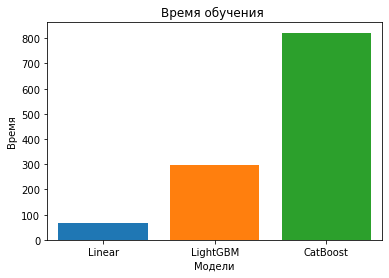

Wall time: 19min 47s


In [14]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

In [15]:
models

{'Linear': [GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=666),
               n_jobs=-1,
               param_grid={'class_weight': ['balanced', None], 'penalty': ['l2'],
                           'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                      'saga']},
               scoring='f1'),
  {'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}],
 'LightGBM': [GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=666), n_jobs=-1,
               param_grid={'learning_rate': [0.001, 0.01, 0.1],
                           'max_depth': range(1, 10, 2),
                           'n_estimators': range(1, 500, 25)},
               scoring='f1'),
  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 476}],
 'CatBoost': [GridSearchCV(cv=5,
               estimator=<catboost.core.CatBoostClassifier object at 0x000002081A383D60>,
               n_jobs=-1,
               param_grid={'learning_rate': [0.01, 0.1],

## feature importances
### LightGBM

In [42]:
model = LGBMClassifier(random_state=666, max_depth=9, learning_rate=0.1, n_estimators=475)
model.fit(features_train, target_train)

predictions = model.predict(features_test)

Text(0, 0.5, 'Mean decrease in impurity')

<Figure size 720x936 with 0 Axes>

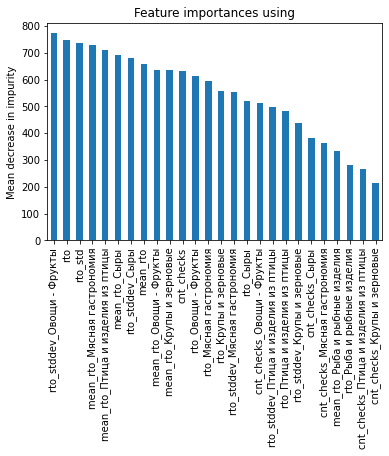

In [49]:
importances = model.feature_importances_

feature_importances = pd.Series(importances, index=features_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,13))
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using")
ax.set_ylabel("Mean decrease in impurity")


In [18]:
features_test.columns

Index(['cnt_checks', 'cnt_checks_Крупы и зерновые',
       'cnt_checks_Мясная гастрономия', 'cnt_checks_Овощи - Фрукты',
       'cnt_checks_Птица и изделия из птицы', 'cnt_checks_Сыры', 'rto',
       'rto_Крупы и зерновые', 'rto_Мясная гастрономия', 'rto_Овощи - Фрукты',
       'rto_Птица и изделия из птицы', 'rto_Рыба и рыбные изделия', 'rto_Сыры',
       'rto_std', 'rto_stddev_Крупы и зерновые',
       'rto_stddev_Мясная гастрономия', 'rto_stddev_Овощи - Фрукты',
       'rto_stddev_Птица и изделия из птицы', 'rto_stddev_Сыры',
       'mean_rto_Крупы и зерновые', 'mean_rto_Мясная гастрономия',
       'mean_rto_Овощи - Фрукты', 'mean_rto_Сыры',
       'mean_rto_Рыба и рыбные изделия', 'mean_rto_Птица и изделия из птицы',
       'mean_rto'],
      dtype='object')

In [20]:
features_train, features_test = features_train.drop(columns = ['cnt_checks_Крупы и зерновые', 'cnt_checks_Птица и изделия из птицы']), features_test.drop(columns = ['cnt_checks_Крупы и зерновые', 'cnt_checks_Птица и изделия из птицы'])

### Беггинг

In [33]:
model = BaggingClassifier(random_state=666, n_jobs=-1, base_estimator=LGBMClassifier(max_depth=9, n_estimators=450, learning_rate=0.1), n_estimators=500)
model.fit(features_train, target_train)


BaggingClassifier(base_estimator=LGBMClassifier(max_depth=9, n_estimators=450),
                  n_estimators=500, n_jobs=-1, random_state=666)

In [34]:
predicted = model.predict(features_test)
print(classification_report(target_test, predicted))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     20605
           1       0.51      0.38      0.43      3725

    accuracy                           0.85     24330
   macro avg       0.70      0.66      0.67     24330
weighted avg       0.83      0.85      0.84     24330



In [35]:
f1_score(target_test, predicted)

0.4331939928781545

In [57]:
roc_auc_score(target_test, predicted)

0.6553901851541214

In [52]:
features_test['predict'] = predicted

In [55]:
features_test['predict'].value_counts()

0    21596
1     2734
Name: predict, dtype: int64

In [63]:
features_test.to_csv('result.csv', encoding='cp1251')